# 🚀 BERT Email Classifier Training Notebook

This notebook trains a BERT model to classify emails into different categories using our synthetic dataset.

## get everything running

In your terminal 

In [2]:
import torch, transformers, sklearn, pandas as pd
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("Pandas:", pd.__version__)
print("CUDA:", torch.cuda.is_available())
print("MPS:", torch.backends.mps.is_available())

Torch: 2.7.1
Transformers: 4.55.0
Pandas: 2.3.1
CUDA: False
MPS: True


## 📦 Install Required Packages

Run this cell first to install all necessary dependencies.

In [3]:
!pip install transformers torch datasets accelerate


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


## 🔧 Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Transformers and datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

# Disable wandb logging
import os
os.environ['WANDB_DISABLED'] = 'true'

print('✅ All libraries imported successfully!')

✅ All libraries imported successfully!


## 🧠 BERT Model Setup

This needs to be run at home.

In [8]:
# Initialize tokenizer and model
print('🧠 Setting up BERT model...')

model_name = 'distilbert-base-uncased'
num_labels = len(label_encoder.classes_)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f'Tokenizer loaded: {model_name}')

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels
)
print(f'Model loaded with {num_labels} output classes')

# Move model to device
model = model.to(device)
print(f'Model moved to {device}')

🧠 Setting up BERT model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Tokenizer loaded: distilbert-base-uncased
✅ Model loaded with 6 output classes
✅ Model moved to mps


## STOP HERE UNTIL WORKSHOP

## 🎮 GPU Detection & Setup

GPU's are an awful lot faster. Even on small models like we use. We want to find what GPU is present and use that.

In [5]:
import torch

# Detect and set up GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using CUDA GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Apple MPS GPU (Metal Performance Shaders)')
else:
    device = torch.device('cpu')
    print('No GPU found — using CPU (training will be slower)')

print(f'PyTorch version: {torch.__version__}')
print(f'Using device: {device}')

Using Apple MPS GPU (Metal Performance Shaders)
PyTorch version: 2.7.1
Using device: mps


## 📊 Load and Preprocess Data

You need to get the dataset and be able to load it. This data is in the github. It should find it if you cloned the github but you can copy it in otherwise.

In [6]:
# Load the complete dataset
print('Loading dataset...')
df = pd.read_csv('../data/complete_dataset_augmented.csv')
print(f'Dataset loaded! Shape: {df.shape}')
print(f'Total emails: {len(df)}')
print(f'Categories: {df["Label"].nunique()}')
print('\nCategory distribution:')
print(df['Label'].value_counts())

Loading dataset...
Dataset loaded! Shape: (948, 4)
Total emails: 948
Categories: 6

Category distribution:
Label
CarBreakdown     160
CarTheft         160
CarRenewal       160
CarCrash         160
CarWindshield    160
Other            148
Name: count, dtype: int64


In [7]:
# Data preprocessing
print('Data preprocessing...')

# Combine subject and message
df['text'] = df['Subject'] + ' ' + df['Message']
print(f'Combined text created. Sample length: {len(df["text"].iloc[0])} chars')

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['Label'])
print(f'Labels encoded. Classes: {label_encoder.classes_}')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label_encoded'], 
    test_size=0.2, random_state=42, stratify=df['label_encoded']
)

print('Data split complete:')
print('   Training: {len(X_train)} samples')
print('   Testing: {len(X_test)} samples')
print('   Classes: {len(label_encoder.classes_)}')

🔧 Data preprocessing...
Combined text created. Sample length: 324 chars
Labels encoded. Classes: ['CarBreakdown' 'CarCrash' 'CarRenewal' 'CarTheft' 'CarWindshield' 'Other']
Data split complete:
   Training: {len(X_train)} samples
   Testing: {len(X_test)} samples
   Classes: {len(label_encoder.classes_)}


## 📝 Data Tokenization

Tokenisation means putting the words present into the format that a vector system like an LLM can handle. 

In [9]:
# Tokenize the data
print('Tokenizing data...')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

# Create datasets for HuggingFace
train_ds = pd.DataFrame({'text': X_train, 'label': y_train})
test_ds = pd.DataFrame({'text': X_test, 'label': y_test})

# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_ds)
test_dataset = Dataset.from_pandas(test_ds)

# Tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

print('Data tokenized successfully!')
print(f'   Training samples: {len(train_dataset)}')
print(f'   Test samples: {len(test_dataset)}')

📝 Tokenizing data...


Map:   0%|          | 0/758 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

✅ Data tokenized successfully!
   Training samples: 758
   Test samples: 190


## 🎯 Training Configuration

These settings are an art but the defaults like below are usually good enough for a sanity check. 
The F1 measure is a hard one to explain to the boss but its simple to read. 

In [10]:
# Define compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

# Set batch size based on device
batch_size = 16 if torch.cuda.is_available() else 8
print(f'📦 Using batch size: {batch_size}')

# Training arguments
training_args = TrainingArguments(
    output_dir="./bert-email-classifier",
    do_train=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=50,
    save_total_limit=2,
    # GPU optimizations
    dataloader_pin_memory=True if torch.cuda.is_available() else False,
    fp16=torch.cuda.is_available(), # Use mixed precision on GPU
    gradient_accumulation_steps=2 if torch.cuda.is_available() else 1
)

print('Training configuration set!')

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


📦 Using batch size: 8
✅ Training configuration set!


## 🚀 Model Training

This takes a while. Unless you have a good machine. So run this and take a break

In [13]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Detect and set up GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using CUDA GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Apple MPS GPU (Metal Performance Shaders)')
else:
    device = torch.device('cpu')
    print('No GPU found — using CPU (training will be slower)')
# Train the model
trainer.train()
print('Training complete!')

Using Apple MPS GPU (Metal Performance Shaders)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.051700,0.006528,1.000000,1.000000
2,0.004900,0.001707,1.000000,1.000000
3,0.001800,0.000993,1.000000,1.000000
4,0.001100,0.000754,1.000000,1.000000
5,0.001000,0.000689,1.000000,1.000000


Training complete!


## 📊 Model Evaluation

This evaluation accuracy is too high. It is because it is a fake dataset. 

We will collect enough examples in this workshop to make the dataset more realistic.

In [16]:
# Evaluate the model
print('📊 Evaluating model...')
results = trainer.evaluate()
print('\n📈 Evaluation Results:')
for key, value in results.items():
    print(f'   {key}: {value:.4f}')

📊 Evaluating model...



📈 Evaluation Results:
   eval_loss: 0.0065
   eval_accuracy: 1.0000
   eval_f1: 1.0000
   eval_runtime: 6.6009
   eval_samples_per_second: 28.7840
   eval_steps_per_second: 3.6360
   epoch: 5.0000


🔮 Making predictions...

📋 Classification Report:
               precision    recall  f1-score   support

 CarBreakdown       1.00      1.00      1.00        32
     CarCrash       1.00      1.00      1.00        32
   CarRenewal       1.00      1.00      1.00        32
     CarTheft       1.00      1.00      1.00        32
CarWindshield       1.00      1.00      1.00        32
        Other       1.00      1.00      1.00        30

     accuracy                           1.00       190
    macro avg       1.00      1.00      1.00       190
 weighted avg       1.00      1.00      1.00       190


🔍 Confusion Matrix:


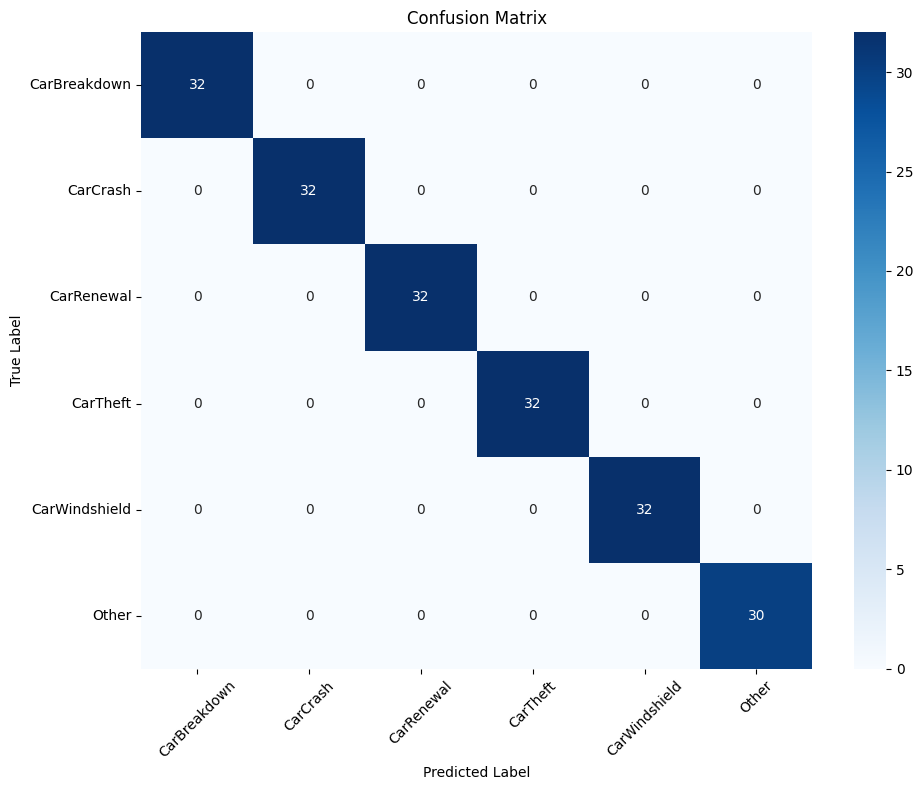

In [17]:
# Make predictions on test set
print('🔮 Making predictions...')
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Classification report
print('\n📋 Classification Report:')
print(classification_report(y_test, pred_labels, target_names=label_encoder.classes_))

# Confusion matrix
print('\n🔍 Confusion Matrix:')
cm = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 💾 Save the Model

In [18]:
# Save the trained model and components
print('Saving model...')

# Create models directory if it doesn't exist
os.makedirs('../streamlit_app/models', exist_ok=True)

# Save model
model_path = '../streamlit_app/models/bert_email_classifier'
trainer.save_model(model_path)
print(f'Model saved to: {model_path}')

# Save tokenizer
tokenizer_path = '../streamlit_app/models/tokenizer'
tokenizer.save_pretrained(tokenizer_path)
print(f'Tokenizer saved to: {tokenizer_path}')

# Save label encoder
import pickle
label_encoder_path = '../streamlit_app/models/label_encoder.pkl'
with open(label_encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f'Label encoder saved to: {label_encoder_path}')

# Save training results
training_results = {
    'model_name': model_name,
    'num_classes': num_labels,
    'classes': label_encoder.classes_.tolist(),
    'evaluation_results': results,
    'training_args': training_args.to_dict()
}

results_path = '../streamlit_app/models/training_results.json'
import json
with open(results_path, 'w') as f:
    json.dump(training_results, f, indent=2)
print(f'Results saved to: {results_path}')

print('\nThe model is ready to be used in the Streamlit app!')

Saving model...
Model saved to: ../streamlit_app/models/bert_email_classifier
Tokenizer saved to: ../streamlit_app/models/tokenizer
Label encoder saved to: ../streamlit_app/models/label_encoder.pkl
Results saved to: ../streamlit_app/models/training_results.json

The model is ready to be used in the Streamlit app!


Just load a model. Is what you want to do next time. When first deploying you will find new examples that should be added to the dataset. But this will reduce over time and you can end up with something like a new model once a sprint. And then later when a system is used a lot it moves back constantly trying to make improvements to it.

In [19]:
Version where we just load the model without the training. 
But we are not using that now so this is left uncommented to cause a syntax error
#


# Load the saved model and components
print('Loading saved model...')

# Load model
model_path = '../streamlit_app/models/bert_email_classifier'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
print(f'Model loaded from: {model_path}')

# Load tokenizer
tokenizer_path = '../streamlit_app/models/tokenizer'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
print(f'Tokenizer loaded from: {tokenizer_path}')

# Load label encoder
import pickle
label_encoder_path = '../streamlit_app/models/label_encoder.pkl'
with open(label_encoder_path, 'rb') as f:
    label_encoder = pickle.load(f)
print(f'Label encoder loaded from: {label_encoder_path}')

# Move model to device (MPS on your Mac)
model = model.to(device)
print(f'Model moved to {device}')

NameError: name 'xxx' is not defined

## User Interface

Simple user interface jst to show that one can be made

In [20]:
# Test the model with some sample emails
def predict_email(text):
    """Predict the category of an email"""
    # Tokenize the input
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=256
    )
    
    # Move inputs to the same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()
    
    return label_encoder.classes_[predicted_class], confidence

# Test with some sample emails
test_emails = [
    "My car was stolen from the parking lot last night. Please help me file a claim.",
    "I need to renew my car insurance policy before it expires next month.",
    "My windshield has a large crack and needs to be replaced.",
    "My car broke down on the highway and I need roadside assistance.",
    "I was involved in a car accident and need to report it."
]

print("🧪 Testing the model with sample emails:")
for i, email in enumerate(test_emails, 1):
    predicted_label, confidence = predict_email(email)
    print(f"\nEmail {i}: {email[:50]}...")
    print(f"Predicted: {predicted_label}")
    print(f"Confidence: {confidence:.4f}")

🧪 Testing the model with sample emails:

Email 1: My car was stolen from the parking lot last night....
Predicted: CarTheft
Confidence: 0.9890

Email 2: I need to renew my car insurance policy before it ...
Predicted: CarRenewal
Confidence: 0.8601

Email 3: My windshield has a large crack and needs to be re...
Predicted: CarWindshield
Confidence: 0.9747

Email 4: My car broke down on the highway and I need roadsi...
Predicted: CarBreakdown
Confidence: 0.8580

Email 5: I was involved in a car accident and need to repor...
Predicted: CarCrash
Confidence: 0.7634


In [21]:
# =============================================================================
# SIMPLE NOTEBOOK UI - Copy this into a new cell in your notebook
# =============================================================================

# Install ipywidgets if needed:
# !pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Simple styling
display(HTML("""
<style>
.ui-container { background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
               padding: 20px; border-radius: 15px; margin: 20px 0; color: white; }
.ui-section { background: rgba(255,255,255,0.1); padding: 15px; border-radius: 10px; margin: 15px 0; }
.ui-button { background: linear-gradient(45deg, #ff6b6b, #ee5a24); border: none; color: white; 
            padding: 12px 24px; border-radius: 25px; font-size: 16px; font-weight: bold; }
.ui-result { background: rgba(255,255,255,0.95); color: #333; padding: 15px; border-radius: 10px; 
            margin: 15px 0; border-left: 5px solid #667eea; }
</style>
"""))

# Create the UI
def create_simple_ui():
    # Header
    header = widgets.HTML(value='<div class="ui-container"><h1>📧 Email Classification Dashboard</h1></div>')
    
    # Input fields
    subject_input = widgets.Text(placeholder='Enter email subject...', description='Subject:', layout=widgets.Layout(width='100%'))
    message_input = widgets.Textarea(placeholder='Enter email message...', description='Message:', layout=widgets.Layout(width='100%', height='100px'))
    
    # Classify button
    classify_button = widgets.Button(description='Classify Email', button_style='success', layout=widgets.Layout(width='200px'))
    
    # Result display
    result_output = widgets.HTML(value='<div class="ui-result">Enter an email above and click "Classify Email" to get started!</div>')
    
    # Classification function
    def on_classify_click(b):
        subject = subject_input.value.strip()
        message = message_input.value.strip()
        
        if not subject and not message:
            result_output.value = '<div class="ui-result" style="border-left-color: #ff6b6b;">⚠️ Please enter either a subject or message.</div>'
            return
        
        try:
            # Combine text
            full_text = f"{subject} {message}".strip()
            
            # Get prediction using the predict_email function from earlier in the notebook
            predicted_label, confidence = predict_email(full_text)
            
            # Color code based on confidence
            if confidence > 0.8:
                border_color = "#28a745"  # Green
            elif confidence > 0.6:
                border_color = "#ffc107"  # Yellow
            else:
                border_color = "#dc3545"  # Red
            
            result_html = f"""
            <div class="ui-result" style="border-left-color: {border_color};">
                <h4>🎯 Classification Result</h4>
                <p><strong>Category:</strong> <span style="color: {border_color}; font-weight: bold;">{predicted_label}</span></p>
                <p><strong>Confidence:</strong> {confidence:.1%}</p>
                <p><strong>Input:</strong> {full_text[:100]}{'...' if len(full_text) > 100 else ''}</p>
            </div>
            """
            
            result_output.value = result_html
            
        except Exception as e:
            result_output.value = f'<div class="ui-result" style="border-left-color: #dc3545;"> Error: {str(e)}</div>'
    
    classify_button.on_click(on_classify_click)
    
    # Layout
    ui = widgets.VBox([
        header,
        widgets.HTML(value='<div class="ui-section"><h3>🔍 Email Classification</h3></div>'),
        subject_input,
        message_input,
        classify_button,
        result_output
    ])
    
    return ui

# Display the UI
print("🎨 Setting up the Email Classification Dashboard...")
ui = create_simple_ui()
display(ui)
print("Dashboard loaded! Enter an email and click 'Classify Email' to test it.") 

🎨 Setting up the Email Classification Dashboard...


✅ Dashboard loaded! Enter an email and click 'Classify Email' to test it.


IT is simple enough to make a training UI that adds values into the csv. But also to add values into the csv yourself.

a really useful add on is 'heres the most similar three emails to this one'. This allows you to check what the answer was to similar queries which is a lot faster than trying to make up your own answer.

Typically you want to the answer to be in the most similar email 50% of the time. Second most similar 20% and third 10%. That still leaves you having to find the answer yourself 20% of the time. But it can be a great saving.

A slightly different sentence bert model is good for this k-nearest neighbour task (https://huggingface.co/embaas/sentence-transformers-e5-large-v2)

## STOP HERE  for the MOMENT

## llm version

In [25]:
Even a small LLM is big so lets not run this until we have good wifi

# Install required packages and download model
print("Installing required packages...")
!pip install transformers torch accelerate

print("Downloading Qwen2.5-1.5B model...")
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "Qwen/Qwen2.5-1.5B-Instruct"
print(f"Model ID: {model_id}")
print("This will download ~3GB model (first time only)")

📦 Installing required packages...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
�� Downloading Qwen2.5-1.5B model...
✅ Model ID: Qwen/Qwen2.5-1.5B-Instruct
�� This will download ~3GB model (first time only)


load the model. This is an LLM model not a BERT one

In [31]:
# Load tokenizer and model
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
print("Tokenizer loaded!")

# Detect device
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple MPS GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using NVIDIA CUDA GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"Device: {device}")

# Load model WITHOUT device_map="auto" to control placement
print("Loading model...")
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16 if device.type == 'cuda' else torch.float32,
    # Remove device_map="auto" to control placement manually
)
print("Model loaded!")

# Move model to our chosen device
model = model.to(device)
print(f"Model moved to: {device}")

# Verify device placement
print(f"Model device check: {next(model.parameters()).device}")

🔄 Loading tokenizer...
✅ Tokenizer loaded!
🍎 Using Apple MPS GPU
🚀 Device: mps
🔄 Loading model...
✅ Model loaded!
✅ Model moved to: mps
�� Model device check: mps:0


make a prompt

In [32]:
# Define the classification prompt
system_prompt = """You are an email classifier for a car insurance company.
Classify emails into exactly one of these categories:
- CarBreakdown: engine problems, battery, tow, stranded
- CarCrash: accidents, collisions, damage from impact  
- CarRenewal: policy renewal, pricing changes
- CarTheft: stolen vehicles, break-ins
- CarWindshield: glass damage, cracks, chips
- Other: general questions not covered above

Format your response as: "Category: Brief explanation"

Examples:
User: "engine died at junction, need a tow"
Assistant: "CarBreakdown: Engine failure requiring assistance"

User: "rear ended at lights, no injuries"
Assistant: "CarCrash: Collision at traffic lights"

User: "renewal price went up 20%"
Assistant: "CarRenewal: Policy renewal with price increase"
"""

print("Classification prompt created:")
print(system_prompt)

Classification prompt created:
You are an email classifier for a car insurance company.
Classify emails into exactly one of these categories:
- CarBreakdown: engine problems, battery, tow, stranded
- CarCrash: accidents, collisions, damage from impact  
- CarRenewal: policy renewal, pricing changes
- CarTheft: stolen vehicles, break-ins
- CarWindshield: glass damage, cracks, chips
- Other: general questions not covered above

Format your response as: "Category: Brief explanation"

Examples:
User: "engine died at junction, need a tow"
Assistant: "CarBreakdown: Engine failure requiring assistance"

User: "rear ended at lights, no injuries"
Assistant: "CarCrash: Collision at traffic lights"

User: "renewal price went up 20%"
Assistant: "CarRenewal: Policy renewal with price increase"



In [33]:
# Test the model with a sample email
def classify_email_llm(email_text, model, tokenizer, system_prompt):
    """Classify email using Qwen2.5-1.5B"""
    
    # Build the prompt with clear boundaries
    prompt = f"{system_prompt}\n\nUser: {email_text}\nAssistant:"
    
    # Tokenize
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    # Generate response with strict stopping
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=20,        # Limit to prevent long responses
            temperature=0.5,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,  # Stop at end token
            repetition_penalty=1.2,   # Prevent repetition
            no_repeat_ngram_size=3    # Prevent repeating phrases
        )
    
    # Decode response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract just the generated part (after "Assistant:")
    generated_text = response[len(prompt):].strip()
    
    # Clean up - remove any extra conversation
    if "\nUser:" in generated_text:
        generated_text = generated_text.split("\nUser:")[0].strip()
    
    return {
        'email': email_text,
        'generated_text': generated_text,
        'full_response': response
    }

# Test with sample emails
test_emails = [
    "My car won't start this morning, battery seems dead",
    "I was rear-ended at the traffic lights yesterday",
    "My windshield has a crack from a stone on the motorway"
]

print("🧪 Testing LLM classification:")
print("=" * 50)

for email in test_emails:
    print(f"\n📧 Email: {email}")
    result = classify_email_llm(email, model, tokenizer, system_prompt)
    print(f"🤖 LLM Response: {result['generated_text']}")
    print("-" * 30)

🧪 Testing LLM classification:

📧 Email: My car won't start this morning, battery seems dead
🤖 LLM Response: Category: CarBreakDown - Battery problem causing the vehicle to fail to start. 

Please note that
------------------------------

📧 Email: I was rear-ended at the traffic lights yesterday
🤖 LLM Response: **"CarCrack: Rear-end collision at traffic light."** 

If you have any other
------------------------------

📧 Email: My windshield has a crack from a stone on the motorway
🤖 LLM Response: Category: CarWindscreen. Glass damage caused by debris while driving.

Please provide me with more details
------------------------------


When to use an LLM

1. Generative task like shown in the table in notebook 1.

2. one with subtle context. Bert will tell you if a topic is discussed. But not subtle differences like 'Windscreen breaks are not covered by this policy'

3. BERT is still really good and low resouce with classification 